## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\Dimitri Salavaci\project 5 data\train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import warnings

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
#Checking whether there are any rows with null values
nan = df[df.isnull().any(1)]
nan

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [13]:
df = df.fillna('')
nan = df[df.isnull().any(1)]
nan

,id,qid1,qid2,question1,question2,is_duplicate


In [14]:
# Total number of question pairs
format(len(df))

'404290'

<AxesSubplot:xlabel='is_duplicate'>

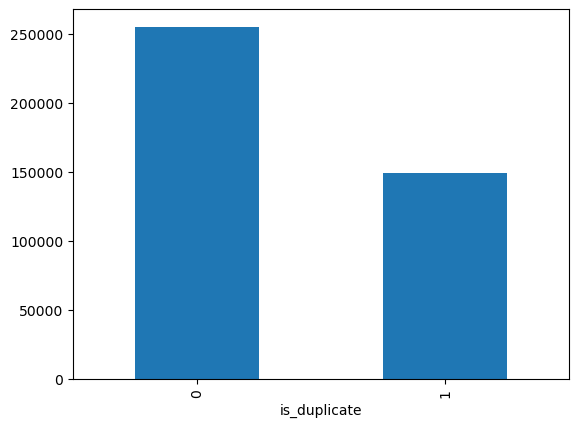

In [16]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [25]:
uni = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
# Total nummber of unique questions 
len_uni = len(np.unique(uni))
#  Number of unique questions that appear more than one time
rep_uni = np.sum(uni.value_counts()> 1)

len_uni, rep_uni

(537933, 111780)

In [26]:
# Max number of times a single question is repeated 
uni.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Length: 537933, dtype: int64

Text(0, 0.5, 'Number of questions')

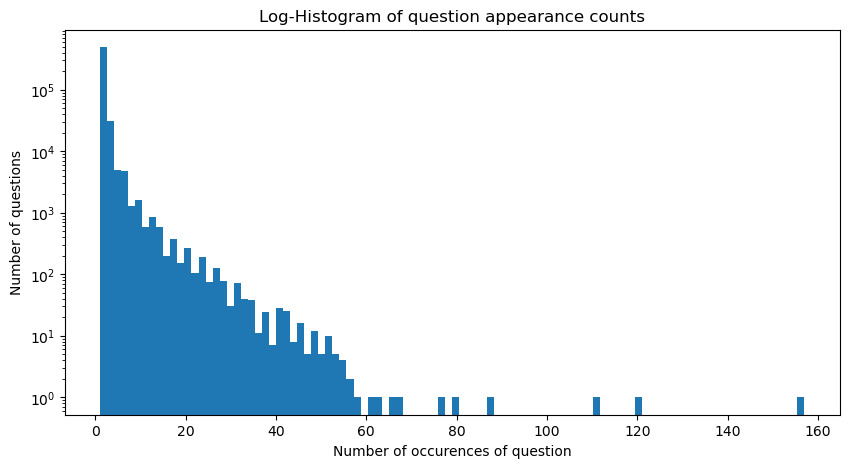

In [29]:
plt.figure(figsize=(10, 5))

plt.hist(uni.value_counts(), bins=100)

plt.yscale('log')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

In [32]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
(pair_duplicates).shape[0] - df.shape[0]

0

# Creating features prior to cleaning(feature engineering)

- freq_qid1 = Frequency of qid1's
- freq_qid2 = Frequency of qid2's
- q1len = Length of q1
- q2len = Length of q2
- q1_n_words = Number of words in Question 1
- q2_n_words = Number of words in Question 2
- word_common = (Number of common unique words in Question 1 and Question 2)
- word_total =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share = (word_common)/(word_total)
- freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
- freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [33]:
df["freq_qid1"]= df.groupby("qid1")["qid1"].transform("count")
df["freq_qid2"]= df.groupby("qid2")["qid2"].transform("count")

df["q1len"]= df["question1"].str.len()
df["q2len"]= df["question2"].str.len()

df["q1_n_words"]= df["question1"].apply(lambda row: len(row.split(" ")))
df["q2_n_words"]= df["question2"].apply(lambda row: len(row.split(" ")))

In [34]:
def normalized_word_common(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * len(w1 & w2)
df['word_common'] = df.apply(normalized_word_common, axis=1)

In [35]:
def normalized_word_total(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * (len(w1) + len(w2))
df['word_total'] = df.apply(normalized_word_total, axis=1)

In [36]:
def normalized_word_share(row):
            w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
            w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
            return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [37]:
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

In [38]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [39]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [40]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the sentence into tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common tokens from question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both questions is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both questions is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average token length of both questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features


In [41]:
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

In [42]:
    # Merging Features with dataset
    
token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))
df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
df["mean_len"]      = list(map(lambda x: x[9], token_features))

In [43]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,0.833319,0.714276,0.999980,0.999980,0.833326,0.714281,0.0,1.0,2.0,13.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,...,0.599988,0.299997,0.499975,0.333322,0.499994,0.307690,0.0,1.0,5.0,10.5
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,...,0.333328,0.249997,0.249994,0.166664,0.299997,0.214284,0.0,1.0,4.0,12.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,10.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,...,0.166664,0.090908,0.999900,0.499975,0.285710,0.153845,0.0,1.0,6.0,10.0


In [44]:
df_duplicate= df[df["is_duplicate"]== 1]
df_nonduplicate= df[df["is_duplicate"]== 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
positive= np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
negative= np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(positive))
print ("Number of data points in class 0 (non duplicate pairs) :",len(negative))

#Saving the np array OR all the text in positive and negative class into a text file which help us to plot word cloud
np.savetxt('train_positive.txt', positive, delimiter=' ', fmt='%s', encoding= "utf-8")
np.savetxt('train_negative.txt', negative, delimiter=' ', fmt='%s', encoding= "utf-8")

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


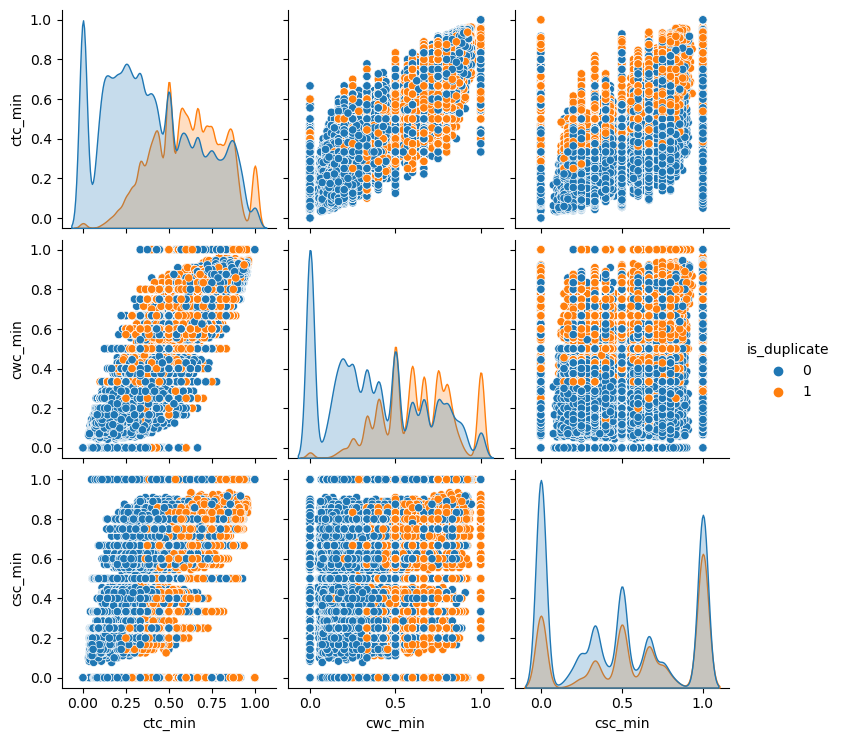

In [47]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min'])
plt.show()

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [49]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import sys
from tqdm import tqdm
import spacy

In [50]:
# encode questions to unicode
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,0.833319,0.714276,0.999980,0.999980,0.833326,0.714281,0.0,1.0,2.0,13.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,...,0.599988,0.299997,0.499975,0.333322,0.499994,0.307690,0.0,1.0,5.0,10.5


In [51]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_)) 

c:\Users\Dimitri Salavaci\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
nlp = spacy.load('en_core_web_sm')
vecs1 = []

for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    
    # 96 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1),len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2),len(doc2[0].vector)])     
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [63]:
Total_Y = df['is_duplicate'].values
Total_X = df.drop(['is_duplicate'],axis=1)

In [64]:
from sklearn.model_selection import train_test_split
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(Total_X, Total_Y, test_size=0.33)

In [65]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (270874, 30)
Number of data points in test data : (133416, 30)


In [66]:
print(f"Train Data : ({len(X_train)} , {len(y_train)})")
print(f"Test Data : ({len(X_test)} , {len( y_test)})")

Train Data : (270874 , 270874)
Test Data : (133416 , 133416)


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
question_1 = list(X_train['question1'])
question_2 = list(X_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf_2 = TfidfVectorizer(lowercase=False, )
word2tfidf_1 = tfidf.fit_transform(question_1)
word2tfidf_2 = tfidf_2.fit_transform(question_2)

# dict key:word and value:tf-idf score
#word2tfidf_1 = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
print(word2tfidf_1.shape, y_train.shape)
print(word2tfidf_2.shape, y_train.shape)

(270874, 70499) (270874,)
(270874, 65152) (270874,)


In [68]:

question_test_1 = list(X_test['question1'])
question_test_2 = list(X_test['question2'])


word2tfidf_test_1 = tfidf.transform(question_test_1)
word2tfidf_test_2 = tfidf_2.transform(question_test_2)

# dict key:word and value:tf-idf score
#word2tfidf_1 = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
print(word2tfidf_test_1.shape, y_test.shape)
print(word2tfidf_test_2.shape, y_test.shape)

(133416, 70499) (133416,)
(133416, 65152) (133416,)


In [69]:
from scipy.sparse import hstack

word2tfidf = hstack((word2tfidf_1, word2tfidf_2)) # stacking the sparse matrices
word2tfidf_test = hstack((word2tfidf_test_1, word2tfidf_test_2))

In [70]:
#make a fresh dataframe with obtained features
New_data = X_train.drop(['qid1','qid2', 'id','question1','question2'], axis=1)
New_test_data = X_test.drop(['qid1','qid2', 'id','question1','question2'], axis=1)

In [71]:

X_train= hstack((word2tfidf, New_data))

In [72]:
X_test= hstack((word2tfidf_test, New_test_data))

In [73]:

X_train

<270874x135676 sparse matrix of type '<class 'numpy.float64'>'
	with 11445708 stored elements in COOrdinate format>

In [74]:
X_test

<133416x135676 sparse matrix of type '<class 'numpy.float64'>'
	with 5599307 stored elements in COOrdinate format>

In [76]:
import time

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

clf = xgb.XGBClassifier(objective= 'binary:logistic',eval_metric='logloss')

param_grid = {'max_depth' : [2,3,4,5],'n_estimators' : [100,200,300,400,500,600,700],'learning_rate' : [0.1,1]}

#fit_params = {'objective': 'binary:logistic','eval_metric': 'logloss'}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, cv=2,
                            scoring='neg_log_loss')
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in tqdm(sorted(best_params.keys())):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..


c:\Users\Dimitri Salavaci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Dimitri Salavaci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Dimitri Salavaci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Dimitri Salavaci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\Dimitri Salavaci\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labe

Randomized search time: 1495.788141489029
Best score: -0.3233279913198307
Best params: 


100%|██████████| 3/3 [00:00<?, ?it/s]

learning_rate: 0.1
max_depth: 5
n_estimators: 600


In [77]:
X_train.shape

(270874, 135676)

In [78]:
X_test.shape

(133416, 135676)

In [82]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, log_loss

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['n_estimators'] = 600
params['max_depth'] = 5
params['learning_rate'] = 0.1


d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

c:\Users\Dimitri Salavaci\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[14:43:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-logloss:0.65073	valid-logloss:0.65077
[10]	train-logloss:0.45408	valid-logloss:0.45490
[20]	train-logloss:0.39636	valid-logloss:0.39794
[30]	train-logloss:0.37446	valid-logloss:0.37660
[40]	train-logloss:0.36420	valid-logloss:0.36689
[50]	train-logloss:0.35661	valid-logloss:0.35982
[60]	train-logloss:0.35234	valid-logloss:0.35593
[70]	train-logloss:0.34843	valid-logloss:0.35256
[80]	train-logloss:0.34505	valid-logloss:0.34956
[90]	train-logloss:0.34246	valid-logloss:0.34746
[100]	train-logloss:0.34026	valid-logloss:0.34564
[110]	train-logloss:0.33826	valid-logloss:0.34405
[120]	train-logloss:0.33627	valid-logloss:0.34254
[130]	train-logloss:0.33429	valid-logloss:0.34103
[140]	train-logloss:0.33278	valid-logloss:0.33989
[150]	train-logloss:0.33141	valid-logloss:0.33889
[160]	tra

In [85]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Total number of data points : 133416


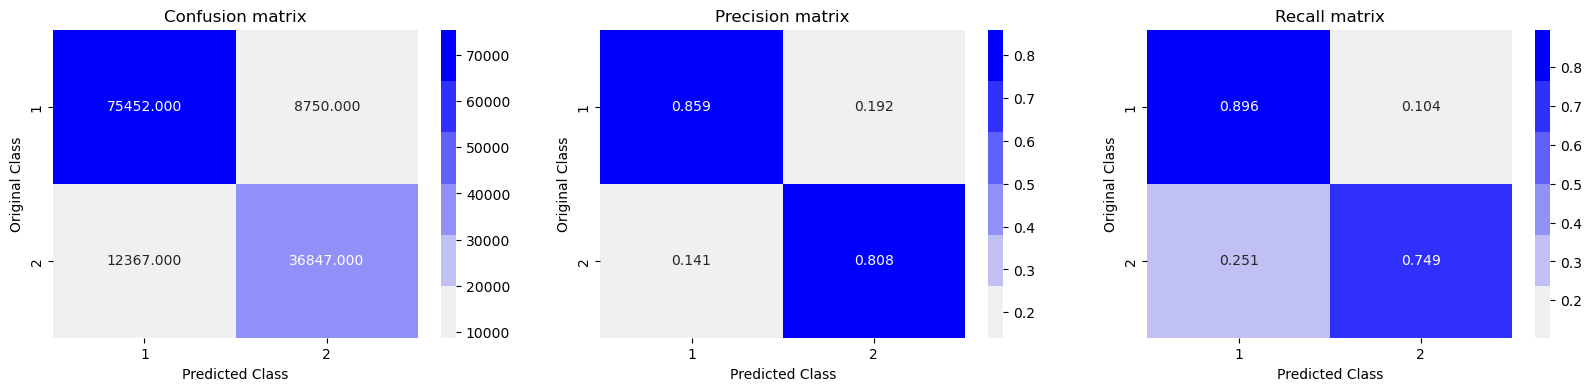

In [87]:
predicted_y = np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [88]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

 14%|█▍        | 1/7 [03:52<23:16, 232.74s/it]

For values of alpha =  1e-05 The log loss is: 0.38793042468534067


 29%|██▊       | 2/7 [06:12<14:48, 177.76s/it]

For values of alpha =  0.0001 The log loss is: 0.39176163191301205


 43%|████▎     | 3/7 [06:53<07:41, 115.45s/it]

For values of alpha =  0.001 The log loss is: 0.42326767695010514


 57%|█████▋    | 4/7 [07:06<03:45, 75.21s/it] 

For values of alpha =  0.01 The log loss is: 0.4478027515526556


 71%|███████▏  | 5/7 [07:13<01:40, 50.38s/it]

For values of alpha =  0.1 The log loss is: 0.4638205900143516


 86%|████████▌ | 6/7 [07:17<00:34, 34.67s/it]

For values of alpha =  1 The log loss is: 0.4955326292296796


100%|██████████| 7/7 [07:21<00:00, 63.01s/it]

For values of alpha =  10 The log loss is: 0.547009025495035


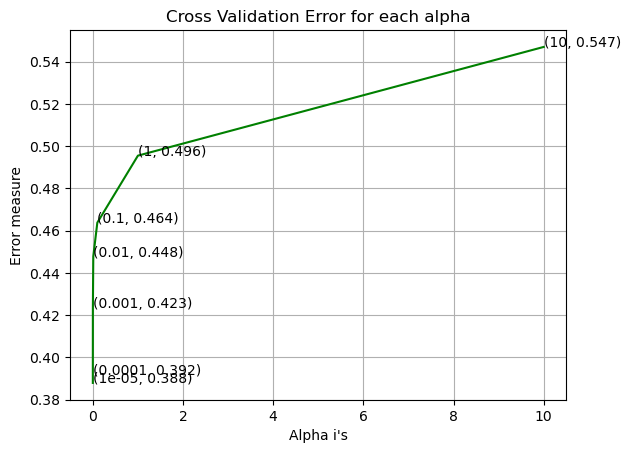

For values of best alpha =  1e-05 The train log loss is: 0.3809698599226905
For values of best alpha =  1e-05 The test log loss is: 0.38793042468534067
Total number of data points : 133416


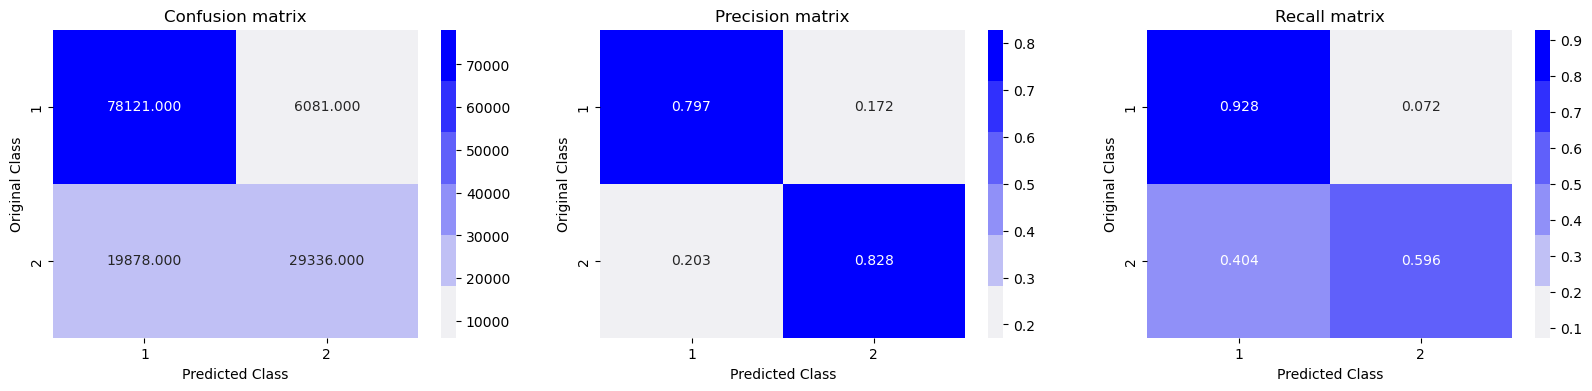

In [89]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [94]:
from prettytable import PrettyTable

x = PrettyTable(["Model",  "Train log loss", "Test log loss"])



x.add_row(["Logistic Regression" , 0.381, 0.387])
x.add_row(["XGB" , 0.32366,  0.323661])

print(x)

+---------------------+----------------+---------------+
|        Model        | Train log loss | Test log loss |
+---------------------+----------------+---------------+
| Logistic Regression |     0.381      |     0.387     |
|         XGB         |    0.32366     |    0.323661   |
+---------------------+----------------+---------------+
